In [42]:
"""
Links:
1- https://github.com/opengeos/segment-geospatial/tree/main
2- https://github.com/ayushdabra/dubai-satellite-imagery-segmentation/tree/main
3- dataspace.copernicus.eu

Datasets:
100points_pixelIntensitiesB4.csv --> it contains red color pixel intensity values each 100 points for a year 
100points_pixelIntensitiesB3.csv --> it contains green color pixel intensity values each 100 points for a year 
100points_pixelIntensitiesB2.csv --> it contains blue color pixel intensity values each 100 points for a year 

The files which are in below contain different infrared pixel intensity values each 100 points for a year
100points_pixelIntensitiesB9.csv, 100points_pixelIntensitiesB10.csv, 100points_pixelIntensitiesB10.csv 

10k_random.csv --> it contains coordinates of random 100 points in baltic region
100points_iou.csv --> it contains iou values of each 100 points for a year which were gotten using SAMGeo segmentation model
100points_scores.csv --> it contains score values of each 100 points for a year which were gotten using SAMGeo segmentation model (predict function)

100points_probabilities.json --> it contains segmentation class probabilities of center pixel of each image. 2nd github link was used for that
VAR_results.json --> it contains VAR Model result for each 100 points. Structure of the json is in below.
                     [
                        {
                            'rmse_results': {
                                'rmse_b4': rmse_result[0], 'rmse_b3': rmse_result[1], 'rmse_b2': rmse_result[2],
                                'rmse_iou': rmse_result[3], 'rmse_score': rmse_result[4],
                                'rmse_class1': rmse_result[5], 'rmse_class2': rmse_result[6], 'rmse_class3': rmse_result[7],
                                'rmse_class4': rmse_result[8], 'rmse_class5': rmse_result[9], 'rmse_class6': rmse_result[10]
                            },
                            'aic': aic,
                            'confidence_intervals': {
                                'conf_mid_b4': conf_mid_b4.tolist(), 'conf_lower_b4': conf_lower_b4.tolist(), 'conf_upper_b4': conf_upper_b4.tolist(),
                                'conf_mid_b3': conf_mid_b3.tolist(), 'conf_lower_b3': conf_lower_b3.tolist(), 'conf_upper_b3': conf_upper_b3.tolist(),
                                'conf_mid_b2': conf_mid_b2.tolist(), 'conf_lower_b2': conf_lower_b2.tolist(), 'conf_upper_b2': conf_upper_b2.tolist(),
                                'conf_mid_iou': conf_mid_iou.tolist(), 'conf_lower_iou': conf_lower_iou.tolist(), 'conf_upper_iou': conf_upper_iou.tolist(),
                                'conf_mid_score': conf_mid_score.tolist(), 'conf_lower_score': conf_lower_score.tolist(), 'conf_upper_score': conf_upper_score.tolist(),
                                'conf_mid_class1': conf_mid_class1.tolist(), 'conf_lower_class1': conf_lower_class1.tolist(), 'conf_upper_class1': conf_upper_class1.tolist(),
                                'conf_mid_class2': conf_mid_class2.tolist(), 'conf_lower_class2': conf_lower_class2.tolist(), 'conf_upper_class2': conf_upper_class2.tolist(),
                                'conf_mid_class3': conf_mid_class3.tolist(), 'conf_lower_class3': conf_lower_class3.tolist(), 'conf_upper_class3': conf_upper_class3.tolist(),
                                'conf_mid_class4': conf_mid_class4.tolist(), 'conf_lower_class4': conf_lower_class4.tolist(), 'conf_upper_class4': conf_upper_class4.tolist(),
                                'conf_mid_class5': conf_mid_class5.tolist(), 'conf_lower_class5': conf_lower_class5.tolist(), 'conf_upper_class5': conf_upper_class5.tolist(),
                                'conf_mid_class6': conf_mid_class6.tolist(), 'conf_lower_class6': conf_lower_class6.tolist(), 'conf_upper_class6': conf_upper_class6.tolist()
                            }
                        }
                    ]
"""
"""
1- create fall in confidence interval column 1 --> prediction is in CI, 0 --> not
2- If CI is 0, calculate the error and save image
"""
import numpy as np
import pandas as pd
import json
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse

Read Data

In [56]:
index = 6 

# Read Json
json_path = 'data/100points_probabilities.json'

with open(json_path, 'r') as dosya:
    json_data = json.load(dosya)

# Get class class probabilities
class1_data = [entry['classes']['class1'] for entry in json_data[str(index)]]
class2_data = [entry['classes']['class2'] for entry in json_data[str(index)]]
class3_data = [entry['classes']['class3'] for entry in json_data[str(index)]]
class4_data = [entry['classes']['class4'] for entry in json_data[str(index)]]
class5_data = [entry['classes']['class5'] for entry in json_data[str(index)]]
class6_data = [entry['classes']['class6'] for entry in json_data[str(index)]]

# Get date
date = [entry['date'] for entry in json_data[str(index)]]

# Read csv
pixel_df4 = pd.read_csv('data/100points_pixelIntensitiesB4.csv')
pixel_df3 = pd.read_csv('data/100points_pixelIntensitiesB3.csv')
pixel_df2 = pd.read_csv('data/100points_pixelIntensitiesB2.csv')
iou_df = pd.read_csv('data/100points_iou.csv')
scores_df = pd.read_csv('data/100points_scores.csv')
cloud_df = pd.read_csv('data/cloud_prob_index6.csv')
cloud = cloud_df['cloud_prob']

In [57]:
"""
This cell prepares "concat" dataframe for VAR Model.
Columns --> ['Pixel_Intensity_B4', 'Pixel_Intensity_B3', 'Pixel_Intensity_B2', 
            'IOU', 'Scores', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6']
"""

pixel_b4 = pixel_df4[[str(index)]]
pixel_b3 = pixel_df3[[str(index)]]
pixel_b2 = pixel_df2[[str(index)]]
iou = iou_df[[str(index)]]
scores = scores_df[[str(index)]]
class1_df = pd.DataFrame(class1_data)
class2_df = pd.DataFrame(class2_data)
class3_df = pd.DataFrame(class3_data)
class4_df = pd.DataFrame(class4_data)
class5_df = pd.DataFrame(class5_data)
class6_df = pd.DataFrame(class6_data)

concat = pd.concat([pixel_b4, pixel_b3, pixel_b2, iou, scores,
                    class1_df, class2_df, class3_df, class4_df, class5_df, class6_df, cloud], axis=1)

concat.columns = ['Pixel_Intensity_B4', 'Pixel_Intensity_B3', 'Pixel_Intensity_B2', 
                  'IOU', 'Scores', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Cloud']

# concat['Mean_rgb'] = concat[['Pixel_Intensity_B4', 'Pixel_Intensity_B3', 'Pixel_Intensity_B2']].mean(axis=1)
concat = concat.dropna()

In [58]:
concat

,Pixel_Intensity_B4,Pixel_Intensity_B3,Pixel_Intensity_B2,IOU,Scores,Class1,Class2,Class3,Class4,Class5,Class6,Cloud
0,3105.0,2399.0,2068.0,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,9.0
1,3105.0,2399.0,2068.0,1.027471,0.986209,0.116552,0.843368,0.012103,0.001406,0.004809,0.021762,9.0
2,3401.0,2627.0,2223.0,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,5.0
3,3401.0,2626.0,2223.0,1.027471,0.986209,0.130134,0.827013,0.012800,0.001506,0.005070,0.023477,6.0
4,3418.0,2596.0,2204.0,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
67,4776.0,3941.0,3527.0,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,34.0
68,4779.0,3965.0,3571.0,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,34.0
69,4779.0,3965.0,3571.0,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,62.0
70,4663.0,3886.0,3481.0,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,62.0


Visualization of Class Parameters

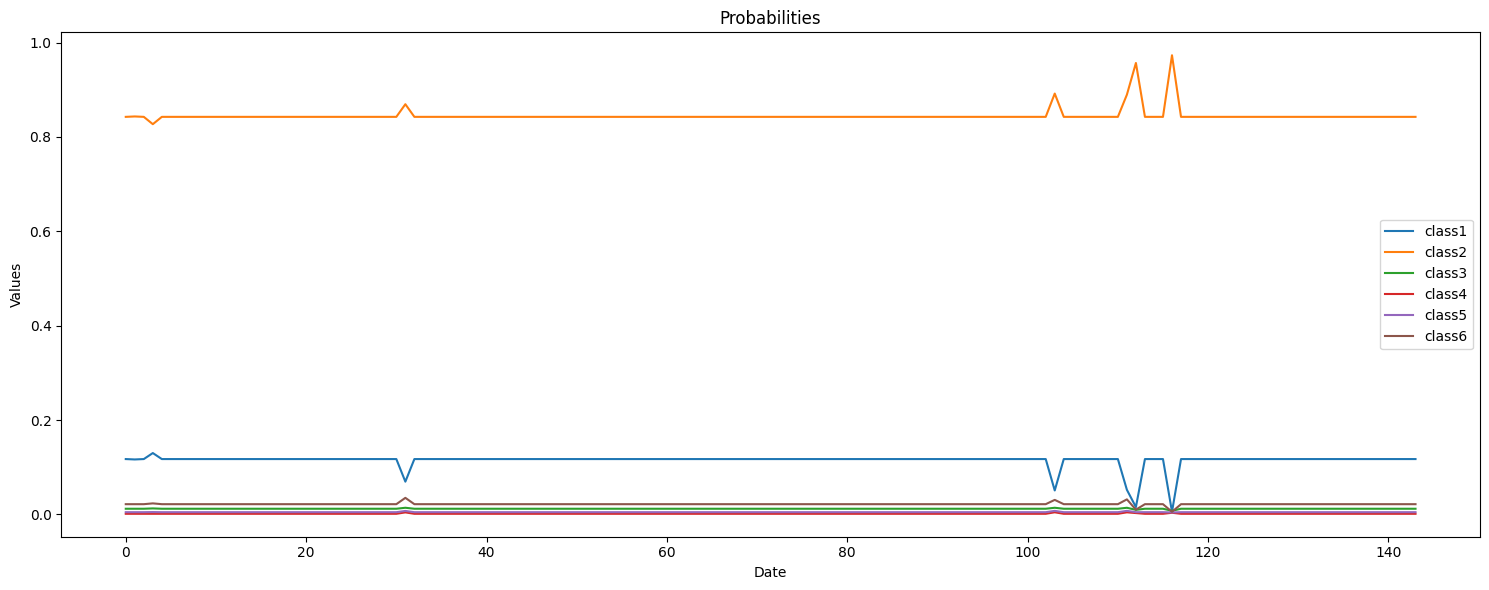

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.plot(class1_df, label='class1')
plt.plot(class2_df, label='class2')
plt.plot(class3_df, label='class3')
plt.plot(class4_df, label='class4')
plt.plot(class5_df, label='class5')
plt.plot(class6_df, label='class6')
plt.title('Probabilities')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

VAR Model

In [60]:
"""
forecast_ci returns 3 confidence values for each forecasting dates.
forecast_ci[:, :, :] --> (confidence_values, rows, columns), in this case the shape is usually (3, rows, 11)
forecast_ci[0:1, :, :] --> returns medium confidence values for all rows and columns
forecast_ci[1:2, :, :] --> returns the lowest confidence values for all rows and columns
forecast_ci[2:, :, :] --> --> returns the highest confidence values for all rows and columns
"""
import scipy.stats as st
import math

noise_factor = 0.005
means = []
try:
    model = VAR(concat)
    model_fitted = model.fit()

    lag_order = model_fitted.k_ar

    forecast = model_fitted.forecast(concat.values[-lag_order:], steps=12) # forecasting for 12 days                       

    for column in concat.columns:
        means.append(np.mean(concat[column]))

    low_conf, high_conf = st.t.interval(confidence=0.999, df=len(concat)-1, 
                                        loc=means, 
                                        scale=st.sem(concat)) 
    
    # forecast_ci = model_fitted.forecast_interval(concat.values[-lag_order:], steps=12, alpha=0.5)
    # forecast_ci = np.array(forecast_ci)

    # Root Mean Squared Error 
    rmse_result = rmse(concat.values[-lag_order:], forecast) 

    # Akaike Information Criteria
    try:
        aic = model_fitted.aic
    except np.linalg.LinAlgError: # If a value is negative, aic function returns LinAlgError
        aic = None

except ValueError: 
    '''
    If a column is constant, VAR model doesn't work. 
    To prevent this situation small amount of noise is added to columns
    '''
    for column in concat.columns:
        noise = np.random.normal(0, noise_factor, concat.shape[0])
        concat[column] = concat[column] + noise
        
    model = VAR(concat)
    model_fitted = model.fit()

    lag_order = model_fitted.k_ar
    forecast = model_fitted.forecast(concat.values[-lag_order:], steps=12) # forecasting for 12 days

    for column in concat.columns:
        means.append(np.mean(concat[column]))

    low_conf, high_conf = st.t.interval(confidence=0.999, df=len(concat)-1, 
                                        loc=means, 
                                        scale=st.sem(concat)) 

    # forecast_ci = model_fitted.forecast_interval(concat.values[-lag_order:], steps=12, alpha=0.5)
    # forecast_ci = np.array(forecast_ci)

    # Root Mean Squared Error 
    rmse_result = rmse(concat.values[-lag_order:], forecast) 

    # Akaike Information Criteria 
    try:
        aic = model_fitted.aic
    except np.linalg.LinAlgError: # If a value is negative, aic function returns LinAlgError
        aic = None


print(f"Root Mean Squared Error: {rmse_result}")
print(f"Akaike Information Criteria AIC: {aic}")

Root Mean Squared Error: [1.00061485e+02 2.56628745e+01 1.24406463e+01 6.01027973e-04
 2.17528537e-04 9.28379447e-04 5.76323706e-04 3.32412907e-05
 5.17394480e-05 4.49837044e-05 2.27469719e-04 5.98122578e+00]
Akaike Information Criteria AIC: None


/home/kursat/miniconda3/envs/myEnv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Full Dataframe for the selected index

In [61]:
"""
Concat and forecast dataframes are merged.
Date, Fitted and Index columns are added.
Fitted 0 --> It means that, it's row used in VAR Model
Fitted 1 --> It means that, it's row is forecasting data
"""
forecast_df_ = pd.DataFrame(forecast, columns=concat.columns)
forecast_df_['Fitted'] = 1
datetime = pd.to_datetime(date)
begining_date = datetime.max() 

for i in range(len(forecast_df_)):
    begining_date += pd.Timedelta(days=1)
    forecast_df_.at[i, 'Date'] = begining_date.date()

full_df = concat.copy()
# date2 = date[::4]
date2 = date.pop(-1)
full_df['Date'] = date2[::2] # date[::2]
full_df['Fitted'] = 0
full_df = pd.concat([full_df, forecast_df_], axis=0)

full_df['Index'] = range(1, len(full_df) + 1)
full_df

/tmp/ipykernel_7063/1430817643.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-01-01' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  forecast_df_.at[i, 'Date'] = begining_date.date()


,Pixel_Intensity_B4,Pixel_Intensity_B3,Pixel_Intensity_B2,IOU,Scores,Class1,Class2,Class3,Class4,Class5,Class6,Cloud,Date,Fitted,Index
0,3105.000000,2399.000000,2068.000000,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,9.000000,22-23,0,1
1,3105.000000,2399.000000,2068.000000,1.027471,0.986209,0.116552,0.843368,0.012103,0.001406,0.004809,0.021762,9.000000,22-23,0,2
2,3401.000000,2627.000000,2223.000000,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,5.000000,22-23,0,3
3,3401.000000,2626.000000,2223.000000,1.027471,0.986209,0.130134,0.827013,0.012800,0.001506,0.005070,0.023477,6.000000,22-23,0,4
4,3418.000000,2596.000000,2204.000000,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,0.021782,10.000000,22-23,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,4772.687543,3910.294890,3464.533530,1.026869,0.986430,0.116573,0.842977,0.012142,0.001453,0.004853,0.022002,11.183611,2023-01-08,1,79
8,4779.542199,3913.890806,3465.390029,1.026880,0.986427,0.116597,0.842954,0.012143,0.001452,0.004853,0.022002,11.555976,2023-01-09,1,80
9,4786.184316,3917.910400,3467.197678,1.026889,0.986425,0.116614,0.842937,0.012143,0.001452,0.004853,0.022002,11.860676,2023-01-10,1,81
10,4792.533891,3922.143943,3469.650288,1.026896,0.986424,0.116626,0.842925,0.012143,0.001452,0.004853,0.022001,12.098525,2023-01-11,1,82


In [62]:
full_df['B4_CI'] = full_df.apply(lambda row: 1 if row['Pixel_Intensity_B4'] >= low_conf[0] and row['Pixel_Intensity_B4'] <= high_conf[0] else 0, axis=1)
full_df['B3_CI'] = full_df.apply(lambda row: 1 if row['Pixel_Intensity_B3'] >= low_conf[1] and row['Pixel_Intensity_B3'] <= high_conf[1] else 0, axis=1)
full_df['B2_CI'] = full_df.apply(lambda row: 1 if row['Pixel_Intensity_B2'] >= low_conf[2] and row['Pixel_Intensity_B2'] <= high_conf[2] else 0, axis=1)
full_df['IOU_CI'] = full_df.apply(lambda row: 1 if row['IOU'] >= low_conf[3] and row['IOU'] <= high_conf[3] else 0, axis=1)
full_df['Scores_CI'] = full_df.apply(lambda row: 1 if row['Scores'] >= low_conf[4] and row['Scores'] <= high_conf[4] else 0, axis=1)
full_df['Class1_CI'] = full_df.apply(lambda row: 1 if row['Class1'] >= low_conf[5] and row['Class1'] <= high_conf[5] else 0, axis=1)
full_df['Class2_CI'] = full_df.apply(lambda row: 1 if row['Class2'] >= low_conf[6] and row['Class2'] <= high_conf[6] else 0, axis=1)
full_df['Class3_CI'] = full_df.apply(lambda row: 1 if row['Class3'] >= low_conf[7] and row['Class3'] <= high_conf[7] else 0, axis=1)
full_df['Class4_CI'] = full_df.apply(lambda row: 1 if row['Class4'] >= low_conf[8] and row['Class4'] <= high_conf[8] else 0, axis=1)
full_df['Class5_CI'] = full_df.apply(lambda row: 1 if row['Class5'] >= low_conf[9] and row['Class5'] <= high_conf[9] else 0, axis=1)
full_df['Class6_CI'] = full_df.apply(lambda row: 1 if row['Class6'] >= low_conf[10] and row['Class6'] <= high_conf[10] else 0, axis=1)
full_df.to_csv('data/example_result_for_a_point.csv')
full_df

,Pixel_Intensity_B4,Pixel_Intensity_B3,Pixel_Intensity_B2,IOU,Scores,Class1,Class2,Class3,Class4,Class5,...,B3_CI,B2_CI,IOU_CI,Scores_CI,Class1_CI,Class2_CI,Class3_CI,Class4_CI,Class5_CI,Class6_CI
0,3105.000000,2399.000000,2068.000000,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,...,0,0,1,1,1,1,1,1,1,1
1,3105.000000,2399.000000,2068.000000,1.027471,0.986209,0.116552,0.843368,0.012103,0.001406,0.004809,...,0,0,1,1,1,1,1,1,1,1
2,3401.000000,2627.000000,2223.000000,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,...,0,0,1,1,1,1,1,1,1,1
3,3401.000000,2626.000000,2223.000000,1.027471,0.986209,0.130134,0.827013,0.012800,0.001506,0.005070,...,0,0,1,1,0,0,0,1,0,0
4,3418.000000,2596.000000,2204.000000,1.027471,0.986209,0.117377,0.842519,0.012109,0.001404,0.004810,...,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,4772.687543,3910.294890,3464.533530,1.026869,0.986430,0.116573,0.842977,0.012142,0.001453,0.004853,...,1,1,1,1,1,1,1,1,1,1
8,4779.542199,3913.890806,3465.390029,1.026880,0.986427,0.116597,0.842954,0.012143,0.001452,0.004853,...,1,1,1,1,1,1,1,1,1,1
9,4786.184316,3917.910400,3467.197678,1.026889,0.986425,0.116614,0.842937,0.012143,0.001452,0.004853,...,1,1,1,1,1,1,1,1,1,1
10,4792.533891,3922.143943,3469.650288,1.026896,0.986424,0.116626,0.842925,0.012143,0.001452,0.004853,...,1,1,1,1,1,1,1,1,1,1


In [63]:
percentage_1 = (full_df['Class2_CI'].value_counts(normalize=True) * 100).loc[1]
print(f"1'lerin yüzdesi: {percentage_1}%")

1'lerin yüzdesi: 97.59036144578313%


Visualizations

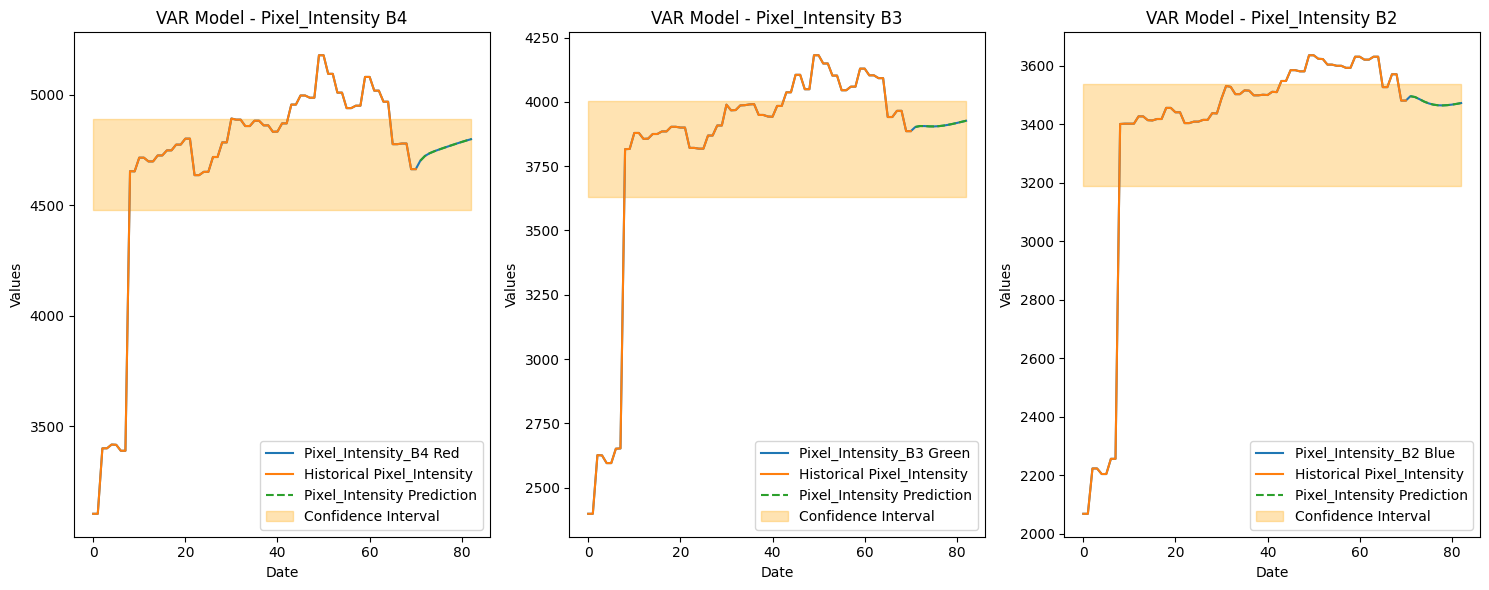

In [64]:
"""
forecast_ci[1:2, :, column_number].flatten(), forecast_ci[2:, :, column_number].flatten() --> alternative confidence interval
concatenated_df['Pixel_Intensity_B4'].iloc[-len(forecast):].index
"""
forecast_df = pd.DataFrame(forecast, columns=concat.columns)
concatenated_df = pd.concat([concat, forecast_df], ignore_index=True)

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.plot(concatenated_df['Pixel_Intensity_B4'], label='Pixel_Intensity_B4 Red')
plt.plot(concatenated_df['Pixel_Intensity_B4'].iloc[:-len(forecast)], label='Historical Pixel_Intensity')
plt.plot(concatenated_df['Pixel_Intensity_B4'].iloc[-len(forecast):], label='Pixel_Intensity Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Pixel_Intensity_B4'].index, low_conf[0], high_conf[0], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Pixel_Intensity B4')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(132)
plt.plot(concatenated_df['Pixel_Intensity_B3'], label='Pixel_Intensity_B3 Green')
plt.plot(concatenated_df['Pixel_Intensity_B3'].iloc[:-len(forecast)], label='Historical Pixel_Intensity')
plt.plot(concatenated_df['Pixel_Intensity_B3'].iloc[-len(forecast):], label='Pixel_Intensity Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Pixel_Intensity_B3'].index, low_conf[1], high_conf[1], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Pixel_Intensity B3')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(133)
plt.plot(concatenated_df['Pixel_Intensity_B2'], label='Pixel_Intensity_B2 Blue')
plt.plot(concatenated_df['Pixel_Intensity_B2'].iloc[:-len(forecast)], label='Historical Pixel_Intensity')
plt.plot(concatenated_df['Pixel_Intensity_B2'].iloc[-len(forecast):], label='Pixel_Intensity Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Pixel_Intensity_B2'].index, low_conf[2], high_conf[2], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Pixel_Intensity B2')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

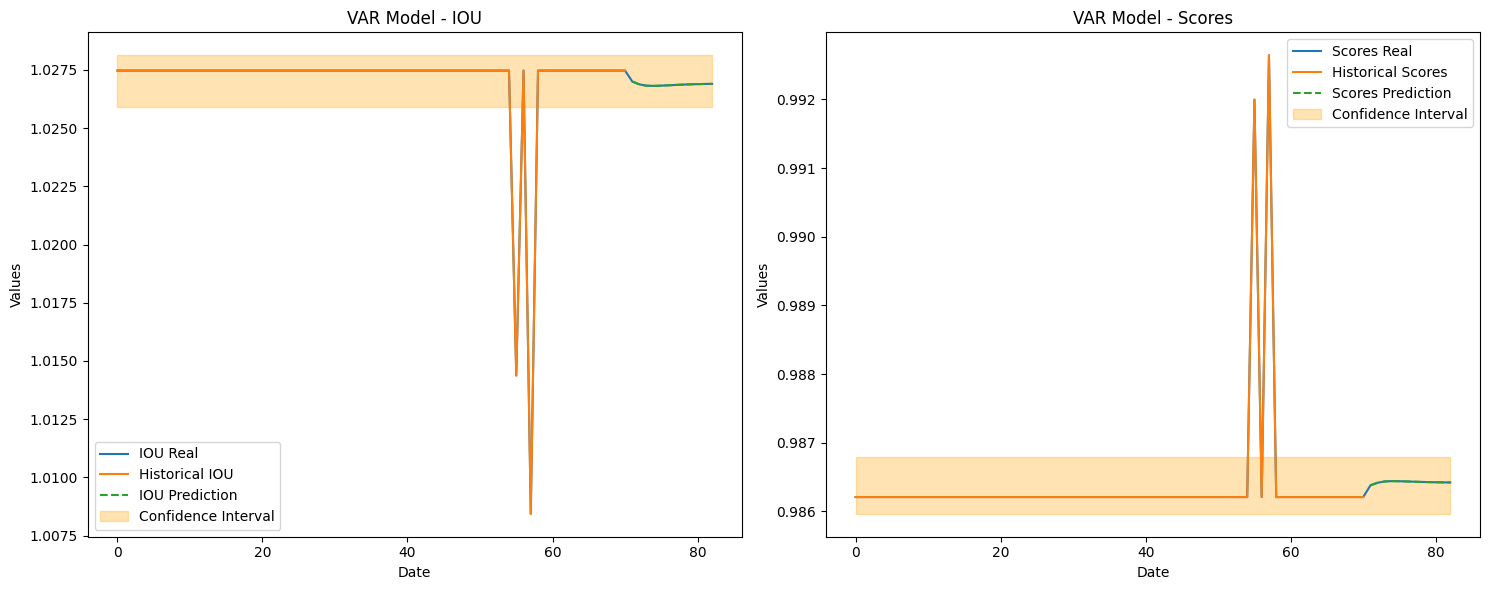

In [65]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(concatenated_df['IOU'], label='IOU Real')
plt.plot(concatenated_df['IOU'].iloc[:-len(forecast)], label='Historical IOU')
plt.plot(concatenated_df['IOU'].iloc[-len(forecast):], label='IOU Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['IOU'].index, low_conf[3], high_conf[3], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - IOU')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(122)
plt.plot(concatenated_df['Scores'], label='Scores Real')
plt.plot(concatenated_df['Scores'].iloc[:-len(forecast)], label='Historical Scores')
plt.plot(concatenated_df['Scores'].iloc[-len(forecast):], label='Scores Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Scores'].index, low_conf[4], high_conf[4], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Scores')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

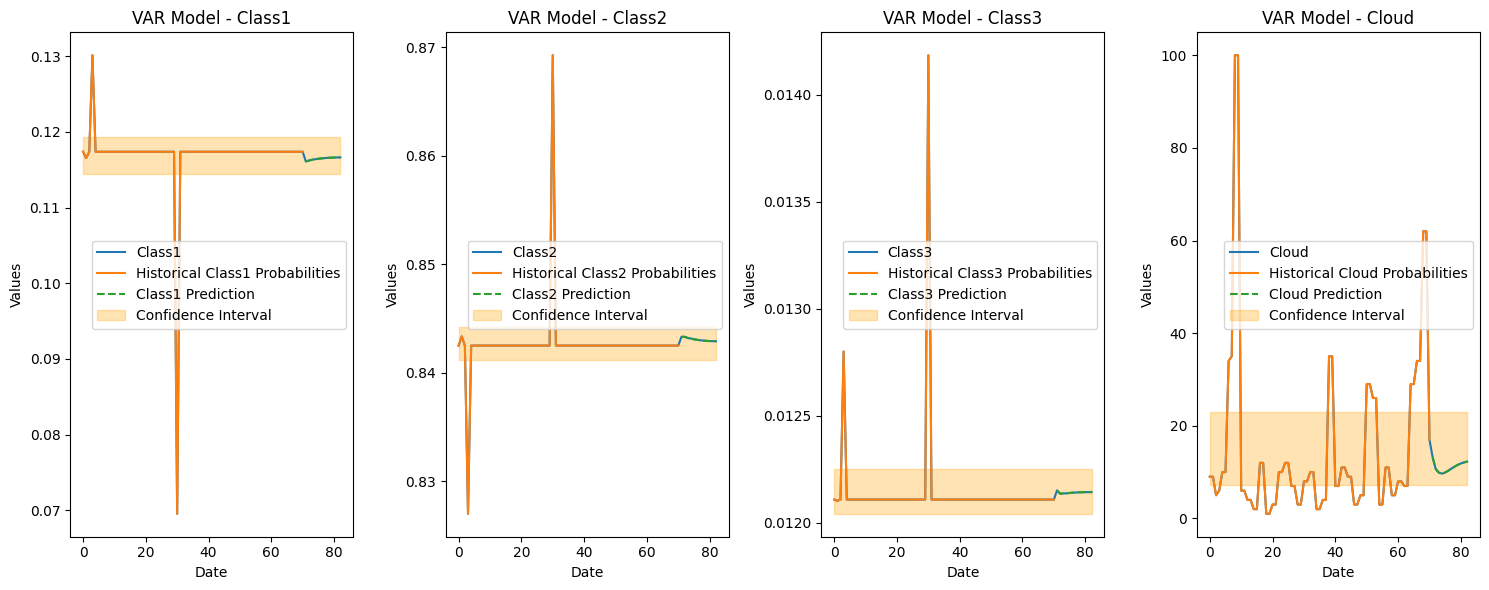

In [66]:
plt.figure(figsize=(15, 6))

plt.subplot(141)
plt.plot(concatenated_df['Class1'], label='Class1')
plt.plot(concatenated_df['Class1'].iloc[:-len(forecast)], label='Historical Class1 Probabilities')
plt.plot(concatenated_df['Class1'].iloc[-len(forecast):], label='Class1 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class1'].index, low_conf[5], high_conf[5], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class1')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(142)
plt.plot(concatenated_df['Class2'], label='Class2')
plt.plot(concatenated_df['Class2'].iloc[:-len(forecast)], label='Historical Class2 Probabilities')
plt.plot(concatenated_df['Class2'].iloc[-len(forecast):], label='Class2 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class2'].index, low_conf[6], high_conf[6], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class2')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(143)
plt.plot(concatenated_df['Class3'], label='Class3')
plt.plot(concatenated_df['Class3'].iloc[:-len(forecast)], label='Historical Class3 Probabilities')
plt.plot(concatenated_df['Class3'].iloc[-len(forecast):], label='Class3 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class3'].index, low_conf[7], high_conf[7], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class3')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(144)
plt.plot(concatenated_df['Cloud'], label='Cloud')
plt.plot(concatenated_df['Cloud'].iloc[:-len(forecast)], label='Historical Cloud Probabilities')
plt.plot(concatenated_df['Cloud'].iloc[-len(forecast):], label='Cloud Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Cloud'].index, low_conf[11], high_conf[11], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Cloud')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

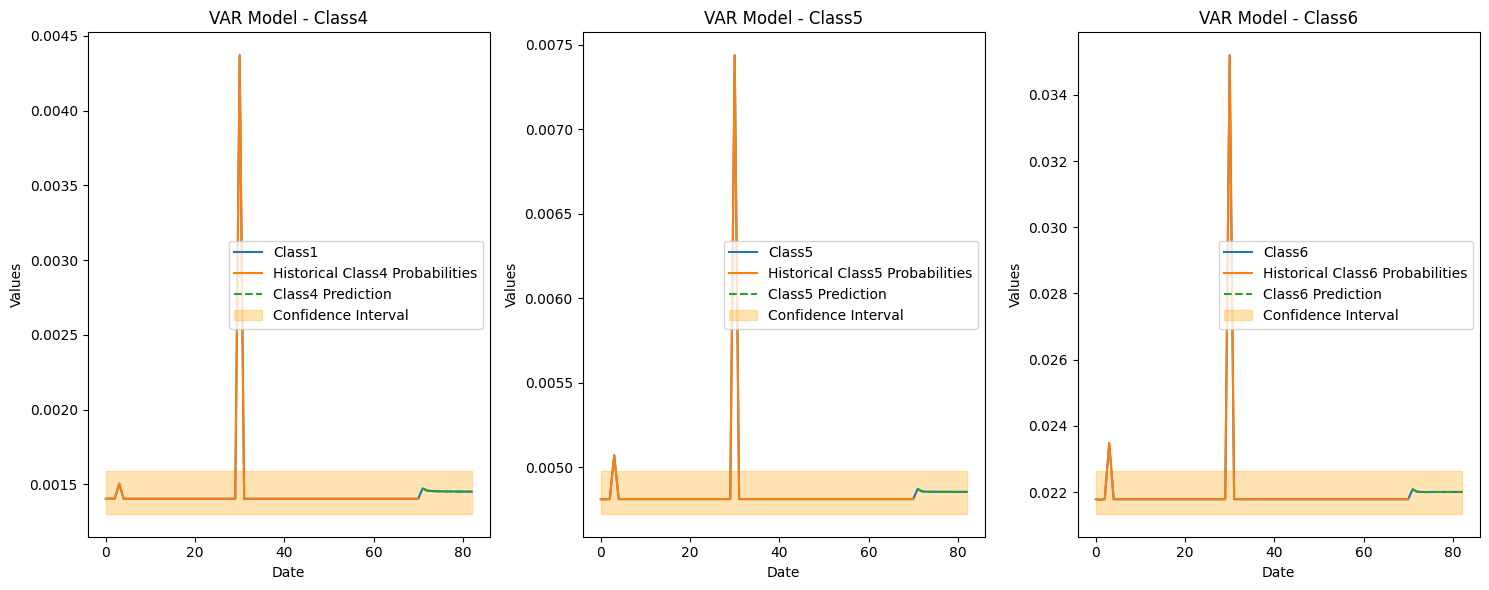

In [67]:
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.plot(concatenated_df['Class4'], label='Class1')
plt.plot(concatenated_df['Class4'].iloc[:-len(forecast)], label='Historical Class4 Probabilities')
plt.plot(concatenated_df['Class4'].iloc[-len(forecast):], label='Class4 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class4'].index, low_conf[8], high_conf[8], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class4')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(132)
plt.plot(concatenated_df['Class5'], label='Class5')
plt.plot(concatenated_df['Class5'].iloc[:-len(forecast)], label='Historical Class5 Probabilities')
plt.plot(concatenated_df['Class5'].iloc[-len(forecast):], label='Class5 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class5'].index, low_conf[9], high_conf[9], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class5')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.subplot(133)
plt.plot(concatenated_df['Class6'], label='Class6')
plt.plot(concatenated_df['Class6'].iloc[:-len(forecast)], label='Historical Class6 Probabilities')
plt.plot(concatenated_df['Class6'].iloc[-len(forecast):], label='Class6 Prediction', linestyle='dashed')
plt.fill_between(concatenated_df['Class6'].index, low_conf[10], high_conf[10], color='orange', alpha=0.3, label='Confidence Interval')
plt.title('VAR Model - Class6')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()